# <font color="orange">SETUP</font>

In [193]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from hpsklearn import HyperoptEstimator, any_classifier
from hyperopt import tpe
from scipy.stats import shapiro, ttest_rel
from plotnine import *
from dfply import *
import math

ModuleNotFoundError: No module named 'hpsklearn'

# <font color="orange">LOAD DATA</font>

In [2]:
df = pd.read_csv("../data/ATP.csv")

In [3]:
df.shape

(169690, 49)

In [4]:
df.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,107760,AUS,Max Senior,NaN,NaN,NaN,1,NaN,R64,12-10 7-5 4-6 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
1,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,106964,AUS,Ernie Mccabe,NaN,NaN,NaN,2,NaN,R64,6-3 6-2 6-4,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.520876,NaN,R,NaN,109803,AUS,John Brown,NaN,NaN,NaN
2,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110024,INA,Gondo Widjojo,NaN,NaN,15.0,3,NaN,R64,6-4 3-6 6-3 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
3,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110025,AUS,Robert Layton,NaN,NaN,NaN,4,NaN,R64,6-4 6-2 6-1,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.264203,NaN,R,NaN,100105,AUS,Allan Stone,NaN,NaN,5.0
4,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110026,AUS,Bert Kearney,NaN,NaN,NaN,5,NaN,R64,6-4 6-1 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN


## <font color="green">DATA DICTIONARY</font>

* `tourney_id` - tournament's id
* `tourney_name` - tournament's name
* `surface` - surface in which the match is played
* `draw_size` - the size of the draw
* `tourney_level` - tournament level ('G' = Grand Slams, 'M' = Masters 1000s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events, 'D' = Davis Cup)
* `tourney_date` - starting date of the tournament
* `match_num` - match number in a certain tournament
* `winner_id` & `loser_id` - player id
* `winner_seed` & `loser_seed` - the seed of the player in that tournament
* `winner_entry` & `loser_entry` - How did the player enter the tournaments? (WC - Wildcard, Q - Qualifier, LL - Lucky loser, PR - Protected ranking, SE - Special Exempt, ALT - Alternate player)
* `winner_name` & `loser_name` - player name
* `winner_hand` & `loser_hand` - hand of the player, right or left
* `winner_ht` & `loser_ht` - the height of the player
* `winner_ioc` & `loser_ioc` - the country of origin
* `winner_age` & `loser_age` - age of the player
* `score` - final score in the match
* `best_of` - the maximum number of sets played
* `round` - the round in the tournament a match belongs to
* `minutes` - duration of the match in minutes
* `w_ace`& `l_ace` - number of aces in the match
* `w_df`& `l_df` - double faults
* `w_svpt`& `l_svpt` - serve percent
* `w_1stIn` & `l_1stIn` - first serve in percent
* `w_1stWon` & `l_1stWon` - first serve winning percent
* `w_2ndWon` & `l_2ndWon` - second serve winning percent
* `w_SvGms` & `l_SvGms` - number of games played on serve (So, the maximum difference between wSvGms and lSvGms will be 1)
* `w_bpSaved` & `l_bpSaved` - breakpoints saved
* `w_bpFaced` & `l_bpFaced` - breakpoints faced

Columns not in the data dictionary:
* `loser_rank`
* `loser_rank_points`
* `winner_rank`
* `winner_rank_points`

In [191]:
df.dtypes

best_of                        int64
l_1stIn                      float64
l_1stWon                     float64
l_2ndWon                     float64
l_SvGms                      float64
l_ace                        float64
l_bpFaced                    float64
l_bpSaved                    float64
l_df                         float64
l_svpt                       float64
loser_age                    float64
loser_entry                   object
loser_hand                    object
loser_ht                     float64
loser_id                       int64
loser_ioc                     object
loser_name                    object
loser_rank                   float64
loser_rank_points            float64
loser_seed                   float64
match_num                      int64
minutes                      float64
tourney_stage                 object
score                         object
surface                       object
tourney_date          datetime64[ns]
tourney_id                    object
t

# <font color="orange">PREMIER NETTOYAGE DE DONNÉES</font>

<font color="grey-black">Renommer la colonne `round` car c'est un mot réservé ("key word") en Python, donc pour éviter toute erreur, mieux vaut changer le nom de la colonne.</font>

In [5]:
df = df.rename({'round': 'tourney_stage'}, axis='columns')

<font color="grey-black">Reordonner le jeu de données par date</font>

In [6]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format="%Y%m%d")
df = df.sort_values(['tourney_date', 'match_num'])

In [7]:
df['tourney_year'] = df['tourney_date'].dt.year

<font color="grey-black">Remplacer la chaine de charactères 'None' dans la colonne `surface` par une valeur manquante `NaN`</font>

In [8]:
df['surface'] = df['surface'].replace({'None': np.nan})

### CREATE DICTIONARY OF PLAYERS WITH STATIC DATA

In [9]:
# first extract ids in loser and winner columns with static columns (and drop duplicates)
losers = df[['loser_id', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc']].drop_duplicates()
winners = df[['winner_id', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc']].drop_duplicates()

In [10]:
# rename columns
for col in losers.columns:
    losers.rename(columns={col: col.split('_')[-1]}, inplace=True)
for col in winners.columns:
    winners.rename(columns={col: col.split('_')[-1]}, inplace=True)

In [11]:
# check for players with same id and different names if any...
print(losers[losers['id'] == losers[losers.duplicated(['id'])]['id'].values[0]])
print(winners[winners['id'] == winners[winners.duplicated(['id'])]['id'].values[0]])

          id                    name hand     ht  ioc
608   100032  Patricio Rodriguez CHI    R  188.0  CHI
1576  100032  Patricio Rodriguez Chi    R  188.0  CHI
          id                    name hand     ht  ioc
541   100032  Patricio Rodriguez CHI    R  188.0  CHI
1656  100032  Patricio Rodriguez Chi    R  188.0  CHI


<font color="grey-black">Patricio Rodriguez a deux noms différents dans le jeu de données, nettoyons ça une bonne fois pour toute.</font>

In [12]:
losers.loc[losers['id'] == 100032, 'name'] = "Patricio Rodriguez"
winners.loc[winners['id'] == 100032, 'name'] = "Patricio Rodriguez"

In [13]:
losers = losers.drop_duplicates()
winners = winners.drop_duplicates()

In [14]:
any(losers.duplicated())

False

<font color="grey-black">Maintenant on peut créer un jeu de données avec les caractéristiques des joueurs à partir de leur IDs.</font>

In [15]:
losers.set_index('id').to_dict(orient='index')[109978]

{'name': 'Tony Pospisil', 'hand': 'U', 'ht': nan, 'ioc': 'CAN'}

In [16]:
players = losers.set_index('id').to_dict(orient='index')
players.update(winners.set_index('id').to_dict(orient='index'))

# create a pandas DataFrame from this dictionary to be able to join it quickly
players_data = pd.DataFrame.from_dict(players, orient='index').reset_index().rename(columns={'index': 'player_id'})

In [17]:
players[109978]

{'name': 'Tony Pospisil', 'hand': 'U', 'ht': nan, 'ioc': 'CAN'}

In [18]:
players_data[players_data['player_id'] == 109978]

,player_id,name,hand,ht,ioc
619,109978,Tony Pospisil,U,NaN,CAN


# <font color="orange">EXPLORATORY DATA ANALYSIS (EDA)</font>

<font color="grey-black">Dans l'EDA, je commence par observer quelques stastiques intéressantes, sur le nombre de matches et de victoires par joueur, puis sur l'évolution du tennis dans le temps. Cela permet de mieux comprendre le jeu de données et de se faire une idée sur ce qu'il peut être fait autour de celui-ci.  
Ensuite, j'étudie quelques statistiques de joueurs dans le jeu de données qui pourraient donner une indication sur la probabilité de tel joueur de gagné contre un autre. Cela permet d'itentifier quelques variables intéressantes pour notre objectif : prédire l'issue d'un match de tennis.  
Après cette partie EDA, je développerai une partie modèle de prédiction.</font>

## <font color="green">STATISTIQUES DES MATCHES ET EVOLUTION DU TENNIS</font>

In [19]:
print("Periode d'observation : du {} au {}".format(min(df['tourney_date']), max(df['tourney_date'])))

Periode d'observation : du 1968-01-19 00:00:00 au 2019-02-25 00:00:00


<font color="grey-black">La période observée concentre donc l'ensemble de [l'ère Open du tennis](https://fr.wikipedia.org/wiki/Ère_Open), c'est-à-dire l'ère moderne du tennis jusqu'au début de l'année 2019.</font>

### <font color="brown">NUMBER OF MATCH PER PLAYER</font>

In [20]:
print("Il y a {} differents joueurs dans le jeu de données, pour {} matches".format(len(players), df.shape[0]))

Il y a 5894 differents joueurs dans le jeu de données, pour 169690 matches


<font color="grey-black">Distribution du nombre de matches par joueur :</font>

In [21]:
nb_lost = df['loser_id'].value_counts().to_frame(name="nb_lost")

nb_win = df['winner_id'].value_counts().to_frame(name="nb_wins")

nb_matches = pd.concat([nb_lost, nb_win], axis=1, sort=False).fillna(0)
nb_matches['total'] = nb_matches['nb_lost'] + nb_matches['nb_wins']
nb_matches = nb_matches.sort_values(['total'], ascending=False)
nb_matches = nb_matches.reset_index().rename({'index': 'player_id'}, axis='columns')

In [22]:
nb_matches = pd.merge(nb_matches, players_data, how='left')

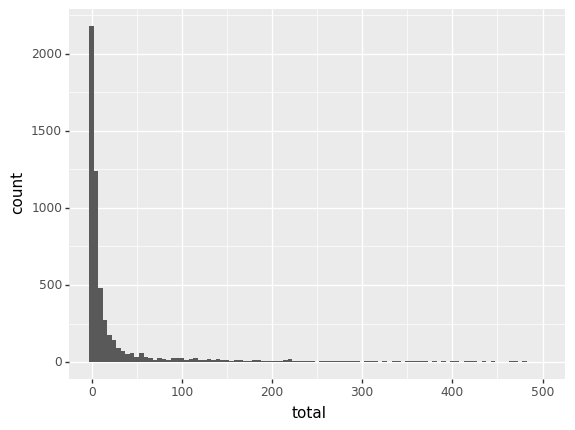

<ggplot: (301771885)>

In [23]:
(
    ggplot(nb_matches, aes(x='total'))
    + geom_histogram(binwidth=5)
    + coord_cartesian(xlim=(0, 500))
)

In [24]:
sum(nb_matches['total'] < 5) / nb_matches.shape[0]

0.48829317950458095

In [25]:
sum(nb_matches['total'] == 1) / nb_matches.shape[0]

0.24584323040380046

<font color="grey-black">Beacoup de joueur n'ont disputé que très peu de matches dans ce jeu de données : environ 49% des joeurs ont moins de 5 matches, et presque un quart des joueurs n'ont fait qu'un match.</font>

<font color="grey-black">Quel joueur ont fait le plus de matches dans leur carrière ?</font>

In [26]:
most_matches = nb_matches.head(10)
most_matches.loc[:,['name']] = pd.Categorical(most_matches['name'], categories=most_matches['name'], ordered=True)

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


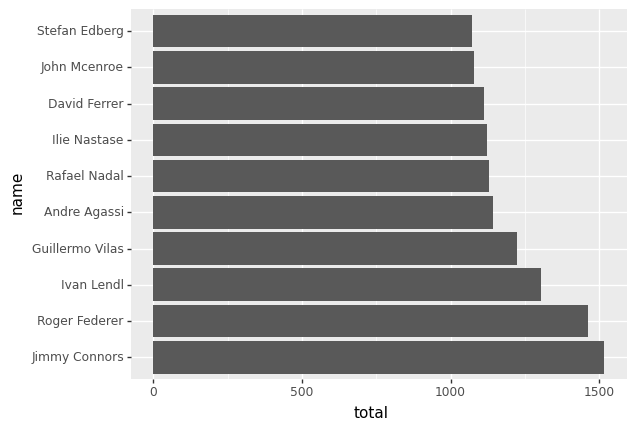

<ggplot: (301972957)>

In [27]:
(
    ggplot(most_matches, aes(x='name', y='total'))
    + geom_bar(stat="identity")
    + coord_flip()
)

<font color="grey-black">On ne retourve que des légendes du jeu (à part peut-être David Ferrer, qui est le seul a ne pas avoir remporté de Grand Chelem). Ce sont des joueurs qui ont beaucoup gagné, et donc disputé beaucoup de matches. Seul 2 joueurs sont encore en activité : Roger Federer et Rafael Nadal.</font>

<font color="grey-black">Quels sont les joueurs qui ont remporté le plus de tournoi ?</font>

In [28]:
top_winners = (
    df >>
    mask(X.tourney_stage == 'F') >>
    select(X.winner_id, X.winner_name, X.tourney_level) >>
    group_by(X.winner_id, X.winner_name, X.tourney_level) >>
    mutate(nb = n(X.winner_id)) >>
    ungroup() >>
    group_by(X.winner_id, X.winner_name) >>
    mutate(total = n(X.winner_id)) >>
    distinct(X.winner_id, X.winner_name, X.tourney_level, X.nb, X.total)
)

In [29]:
top_winners = top_winners.sort_values(['total'], ascending=False)
top_winners['winner_name'] = pd.Categorical(top_winners['winner_name'], categories=top_winners['winner_name'].drop_duplicates(), ordered=True)
top_winners = top_winners[top_winners.winner_name.isin(top_winners.winner_name.drop_duplicates().head(10))]

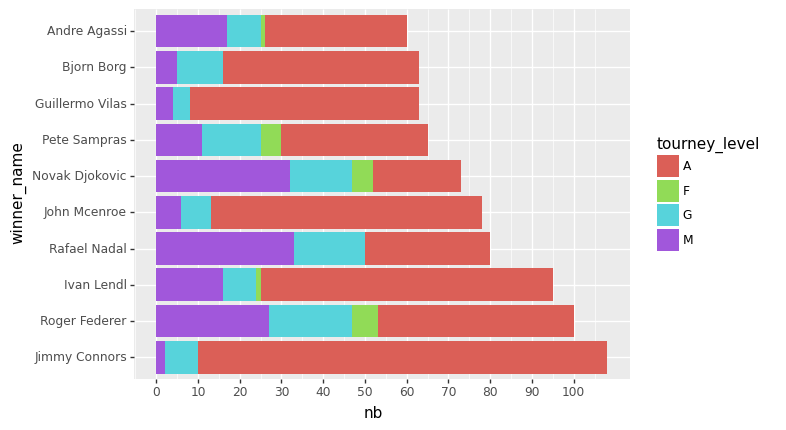

<ggplot: (301866197)>

In [30]:
(
    ggplot(top_winners, aes(x='winner_name', y='nb', fill='tourney_level'))
    + geom_bar(stat="identity")
    + scale_y_continuous(breaks = range(0,max(top_winners['total']), 10))
    + coord_flip()
)

<font color="grey-black">Dans cette première partie, nous avons pu voir certaines informations intéressantes :</font>
- <font color="grey-black">Beaucoup de joueurs ont joué très peu de matches (la moitié, moins de 5 matches, et un quart un seul match).</font>
- <font color="grey-black">Les joueurs qui ont le plus gagné de tournois sont ceux qui ont joué le plus de matches.</font>
- <font color="grey-black">Les légendes du tennis ont joué beaucoup de matches.
Pour pouvoir prédire l'issue d'un match impliquant un joueur, je pense qu'il est nécessaire d'avoir le plus de données possible sur ce joueur en particulier. Ces données étant manquantes, la création de nouvelles variables peut prendre un rôle encore plus importante pour avoir une performance d'un modèle de prédiction.</font>

### <font color="brown">EVOLUTIONS DU TENNIS</font>

<font color="grey-black">On peut se demander quel sont les grandes évolutions qu'a connu le tennis depuis le début de l'ère Open ?</font>

<font color="grey-black">Commençons par regarder l'évolution des différentes surfaces de jeu.</font>

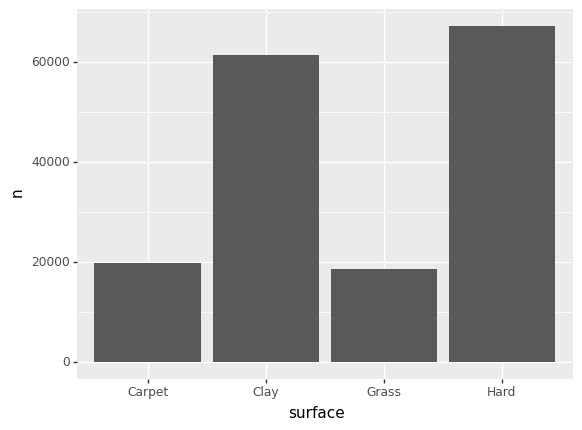

<ggplot: (301950709)>

In [31]:
(
    df >>
    select(X.surface) >>
    group_by(X.surface) >>
    mutate(n=n(X.surface)) >>
    distinct(X.surface, X.n) >>
    ggplot(aes(x='surface', y='n'))
    + geom_bar(stat="identity")
)

<font color="grey-black">La plupart des matches de l'ère Open se sont joués sur terre battue ou dur (ciment).</font>

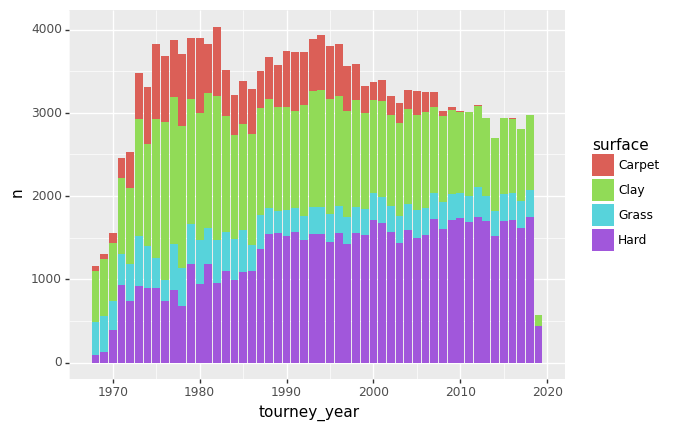

<ggplot: (301953833)>

In [32]:
(
    df >>
    select(X.tourney_year, X.surface) >>
    group_by(X.tourney_year, X.surface) >>
    mutate(n=n(X.tourney_year)) >>
    distinct(X.tourney_year, X.surface, X.n) >>
    ggplot(aes(x='tourney_year', y='n', fill='surface'))
    + geom_bar(stat="identity")
)

<font color="grey-black">Depuis le milieu des années 1990, la moquette a commencé à disparaitre, et en moins de 10 ans, plus aucun tournoi ne se joue sur cette surface. Et de moins en moins de matchs ne disputent sur herbe, peu à peu remplacer par une surface dure. Deux facteurs peuvent expliquer la contraction de cette surface historique du tennis :</font>
- <font color="grey-black">le spectacle est moins télévisuel sur herbe (moins d'échanges, plus de points en un ou deux coups de raquette, etc...) et donc pour attirer les diffuseurs cette surface est abandonée par une parti du circuit mondial de tennis</font>
- <font color="grey-black">les cours de tennis en herbe demandent plus d'entretien que des courts en dur et il eput être compliqué d'entretenir un court en herbe dans certains endroits (comme les pays du Golf, l'Amérique du Sud, etc...) et donc avec la mondialisation du tennis qui s'est accélérée depuis le début de l'ère Open, l'herbe laisse place à des courts en dur ou en terre battue</font>

<font color="grey-black">Le nombre de matches par saison a-t-il évolué depuis lea fin des années soixante ?</font>

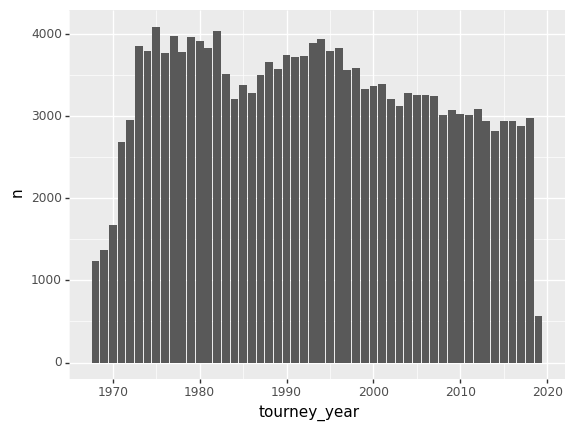

<ggplot: (301968157)>

In [33]:
(
    df >>
    group_by(X.tourney_year) >>
    mutate(n = n(X.match_num)) >>
    ungroup() >>
    distinct(X.n, X.tourney_year) >>
    ggplot(aes(x='tourney_year', y='n'))
    + geom_bar(stat="identity")
)

<font color="grey-black">Depuis le milieu des années 1990, le nombre de match a également baissé. Mais il avait connu une forte augmentation dans les années 1970, pour atteindre presque 4000 matches sur le circuit. Ces dernières années ont plutôt connu environ 3000 matches.</font>

## <font color="green">STATISTIQUES DES JOUEURS ET CORRELATION AVEC LA VICTOIRE</font>

<font color="grey-black">Maintenant, il peut être intéressant de se demander si certaines caractéristiques de joueur (taille, age, main préférée, ...) ont une correlation avec le fait de gagner un match.</font>

### <font color="BROWN">TAILLE DES JOUEURS</font>

<font color="grey-black">Commençons par nous intéressé à la taille d'un joueur.  
Un joueur plus grand a-t-il plus de chance de gagner contre un adversaire plus petit, ou inversement ?
</font>

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 38267 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


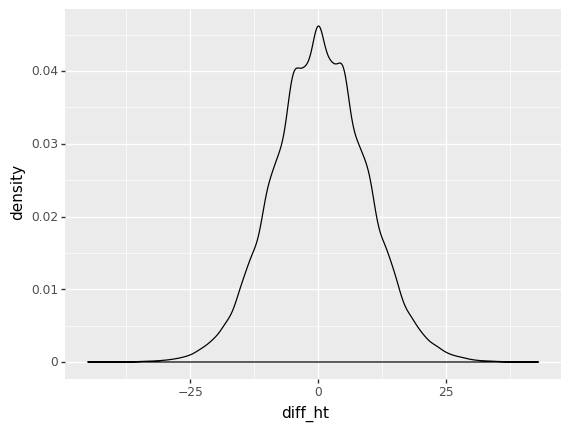

<ggplot: (302801585)>

In [34]:
(
    df >>
    mutate(diff_ht = X.winner_ht - X.loser_ht) >>
    ggplot(aes('diff_ht'))
    + geom_density(adjust=1.5)
)

<font color="grey-black">La différence de taille entre les joueurs s'affrontant ne semble pas être un facteur pour déterminer l'issue du match.  
    Vérifions cela par un test statistique.</font>

In [35]:
ttest_rel(df.winner_ht.fillna(df.winner_ht.append(df.loser_ht).median()),
          df.loser_ht.fillna(df.winner_ht.append(df.loser_ht).median()),
          nan_policy='omit')

Ttest_relResult(statistic=6.011461459955253, pvalue=1.8423165182418132e-09)

<font color="grey-black">Le t-test pairé ne permet pas de conclure sur la non différence des moyennes des tailles des gagnants et des perdants. Il faudrait donc creuser un plus pour comprendre cette différence statistique des deux échantillons. Le test supporte l'idée qu'il existe une différence entre les deux moyennes.</font>

### <font color="brown">AGE DES JOUEURS</font>

<font color="grey-black">Regardons maintenant la variable `age`. Existe-t-il une différence statistique significative entre l'âge des gagnants et celui des perdants qu'on on compare les face à face.</font>

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 6231 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


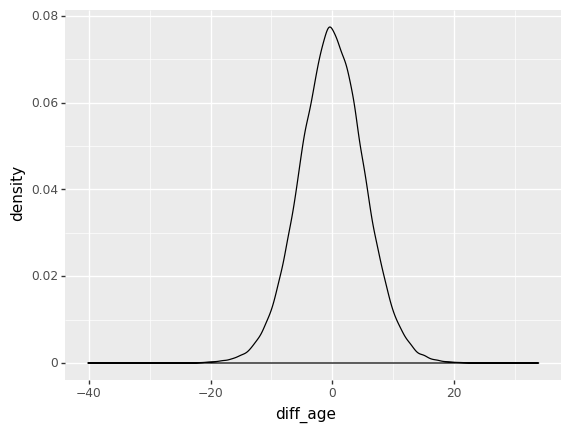

<ggplot: (302806609)>

In [36]:
(
    df >>
    mutate(diff_age = X.winner_age - X.loser_age) >>
    ggplot(aes('diff_age'))
    + geom_density()
)

<font color="grey-black">La différence d'age entre les joueurs s'affrontant ne semble pas non plus être un facteur pour déterminer l'issue du match.</font>

In [37]:
ttest_rel(df.winner_age.fillna(df.winner_age.append(df.loser_age).median()), df.loser_age.fillna(df.winner_age.append(df.loser_age).median()), nan_policy='omit')

Ttest_relResult(statistic=-3.147552815172623, pvalue=0.0016467184540850624)

<font color="grey-black">La différence entre les moyennes de l'âge des gagnants et des perdants est stastiquement différente. Il faudrait donc creuser un plus pour comprendre cette différence statistique des deux échantillons.</font>

### <font color="brown">DROITIER VS GAUCHER</font>

<font color="grey-black">On peut étudier une dernière variable qui est celle de la main préférentielle des joueurs (droitier ou gaucher).</font>

In [38]:
players_data.hand.value_counts(normalize=True)

R    0.691834
U    0.243451
L    0.064715
Name: hand, dtype: float64

<font color="grey-black">Seul 6% des joueurs sont gauchers et 69% sont droitiers (le reste étant non défini).</font>

In [39]:
right_winners = df[(df.winner_hand == 'R') & (df.loser_hand == 'L')]

In [40]:
left_winners = df[(df.winner_hand == 'L') & (df.loser_hand == 'R')]

In [41]:
print("Il y a eu {} face à face entre droitiers et gauchers, et les gauchers en ont remporté {:.2f}%, et représente {:.2f}% du total des victoires".format(
    right_winners.shape[0]+left_winners.shape[0],
    left_winners.shape[0] / (right_winners.shape[0]+left_winners.shape[0]) * 100,
    left_winners.shape[0] / df.shape[0] * 100
)
     )

Il y a eu 40562 face à face entre droitiers et gauchers, et les gauchers en ont remporté 52.30%, et représente 12.50% du total des victoires


<font color="grey-black">Les gauchers ont remporté 12% des matches dans le jeu de données en ne représentant que 6% des joueurs ! Etre gaucher donne plus de chance de remporter un match.</font>

# <font color="orange">MODELES DE PREDICTION</font>

## <font color="green">QUALITÉ DE DONNÉES</font>

<font color="grey-black">Pour pouvoir construire un bon modèle de prédiction, il faut commencer par regarder la qualité du jeu de données. Dans le temps limité de l'exercice, je n'étudie uniquement les valeurs manquantes et l'éventualité de valeurs aberrantes (un age trop jeune ou trop vieux, une taille négative, etc...).</font>

### <font color="brown">DONNÉES ABERRANTES</font>

<font color="grey-black">Je vais rapidement chercher dans le jeu de données pour des données abérrantes (age négatif, taille irréel, etc...).</font>

In [42]:
df.describe()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_ht,loser_id,loser_rank,loser_rank_points,loser_seed,match_num,minutes,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,winner_rank_points,winner_seed,tourney_year
count,169690.000000,1232.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,164700.000000,139052.000000,169690.000000,145909.000000,93025.000000,32853.000000,169690.000000,82103.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,167929.000000,150884.000000,169690.000000,149773.000000,94291.000000,65295.000000,169690.000000
mean,3.446072,75.022727,47.705149,31.683690,15.029119,12.159995,4.779776,8.751555,4.808044,3.509081,80.717904,25.661378,184.064918,102829.308574,120.815721,840.134727,7.589109,52.853492,100.786037,47.299514,35.659522,16.806102,12.354780,6.461823,5.174381,3.528790,2.743859,77.906887,25.612639,184.277200,102362.973540,81.409827,1342.313296,6.209495,1992.990017
std,0.832567,43.500071,19.359849,14.437267,7.266522,4.114587,4.625035,4.123616,3.271050,2.623945,29.485231,4.074386,6.624417,6072.998247,161.539365,940.800241,5.880047,81.992868,40.332392,19.191976,13.841457,7.026601,4.102224,5.297845,4.058311,3.081844,2.368677,29.532338,3.943494,6.632803,3958.369064,123.875156,1672.646568,5.401583,13.970686
min,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,14.380000,160.000000,100001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.360000,160.000000,100002.000000,1.000000,1.000000,1.000000,1968.000000
25%,3.000000,64.000000,34.000000,21.000000,10.000000,9.000000,2.000000,6.000000,2.000000,2.000000,59.000000,22.750000,180.000000,100529.000000,40.000000,367.000000,4.000000,9.000000,73.000000,33.000000,26.000000,12.000000,9.000000,3.000000,2.000000,1.000000,1.000000,56.000000,22.760000,180.000000,100445.000000,18.000000,496.000000,2.000000,1981.000000
50%,3.000000,64.000000,44.000000,29.000000,14.000000,11.000000,4.000000,8.000000,4.000000,3.000000,75.000000,25.320000,185.000000,101736.000000,77.000000,618.000000,6.000000,22.000000,94.000000,44.000000,33.000000,16.000000,11.000000,5.000000,4.000000,3.000000,2.000000,73.000000,25.250000,185.000000,101611.000000,48.000000,835.000000,5.000000,1993.000000
75%,3.000000,128.000000,58.000000,39.000000,19.000000,15.000000,7.000000,11.000000,7.000000,5.000000,96.000000,28.250000,188.000000,103821.000000,134.000000,985.000000,10.000000,45.000000,123.000000,57.000000,43.000000,21.000000,15.000000,9.000000,7.000000,5.000000,4.000000,94.000000,28.130000,188.000000,103694.000000,96.000000,1508.000000,8.000000,2005.000000
max,5.000000,128.000000,328.000000,284.000000,101.000000,91.000000,103.000000,35.000000,28.000000,26.000000,489.000000,63.690000,208.000000,208997.000000,2159.000000,16950.000000,35.000000,701.000000,1146.000000,361.000000,292.000000,82.000000,90.000000,113.000000,34.000000,24.000000,23.000000,491.000000,58.718686,208.000000,208996.000000,2101.000000,16950.000000,35.000000,2019.000000


<font color="grey-black">Il ne semble y avoir de données aberrantes (taille entre 1m60 et 2m08, age entre 14 et 46 ans, ...). Je ne pousserai pas plus loin dans la recherche de données aberrantes.</font>

### <font color="brown">VALEURS MANQUANTES</font>

<font color="grey-black">Je représente l'évolution du nombre de données manquantes par an. Je m'attends à voir plus de valeurs manquantes pour les matches les plus vieux, car on collecte de plus en plus de données dans le monde, et le tennis ne fait pas exception. Surtout sur les plus petits tournois (ATP 250, Challengers, ...).</font>

In [43]:
# creer une nouvelle colonne, du nombre de donnees manquantes par ligne
df['nb_nan'] = df.isnull().sum(axis=1)

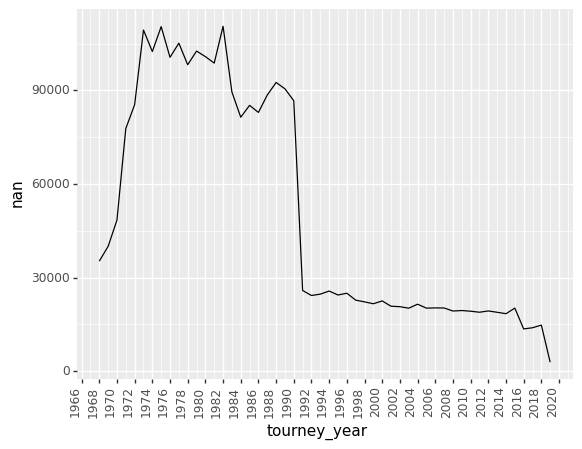

<ggplot: (302810409)>

In [44]:
(
    df >>
    select(X.tourney_year, X.nb_nan) >>
    group_by(X.tourney_year) >>
    summarize(nan = X.nb_nan.sum()) >>
    ggplot(aes(x='tourney_year', y='nan'))
    + geom_line()
    + scale_x_continuous(breaks = range(min(df['tourney_year']) - min(df['tourney_year'])%10,max(df['tourney_year'])+5, 2))
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)

<font color="purple"><b>Les données manquantes concernent principalement les matches d'avant 1992. Pour cette raison, j'ai décidé de restreindre la période de temps du jeu de données utilisé dans la suite. La suite des analyses se fait donc avec les données du 1 er janvier 1992 au début d'année 2019.</b></font>

In [60]:
df = df[df.tourney_year > 1991].reset_index(drop=True)

In [61]:
df.shape

(89100, 51)

<font color="grey-black">Il reste 89100 matches à étudier.</font>

In [63]:
df.isnull().sum()

best_of                   0
draw_size             89100
l_1stIn                8979
l_1stWon               8979
l_2ndWon               8979
l_SvGms                8979
l_ace                  8979
l_bpFaced              8979
l_bpSaved              8979
l_df                   8979
l_svpt                 8979
loser_age               152
loser_entry           71640
loser_hand               43
loser_ht               8527
loser_id                  0
loser_ioc                 0
loser_name                0
loser_rank             2078
loser_rank_points      2829
loser_seed            69521
match_num                 0
minutes               10291
tourney_stage             0
score                     2
surface                 198
tourney_date              0
tourney_id                0
tourney_level             0
tourney_name              0
w_1stIn                8979
w_1stWon               8979
w_2ndWon               8979
w_SvGms                8979
w_ace                  8979
w_bpFaced           

<font color="grey-black">Environ 9000 matches (10% des matches dans le jeu de données) non pas de statistiques sur le déroulé du match (pourcentage de 1er service, de balle de break, du nombre d'aces, etc...). La variable `draw_size` est elle complémtement manquante dans ce nouveau jeu de données.  
Deux options peuvent être envisagé à ce stade, et dans le temps limité: </font>
- <font color="grey-black">Tout simplement les supprimer du jeu de données, mais cela diminuerait encore le nombre de matches disponibles.</font>
- <font color="grey-black">Construire une méthode d'implémentation des données manquantes.</font>

<font color="purple"><b>J'opte pour cette seconde option : pour aller vite, je vais d'abord remplacer les valeurs manquantes par la médiane de la variable.</b></font>

In [64]:
df = df.drop(['draw_size'], axis=1)

In [65]:
df = df.fillna(df.median())

## <font color="green">COORÉLATIONS</font>

## <font color="green">MACHINE LEARNING SETUP</font>

<font color="grey-black">Pour développer mes modèles, je vais construire deux jeux de données : un jeu d'entraînement et un jeu de test. Le jeu d'entraînement sert à construire les modèles de Machine Learning et les ajuster (training), et le second sert à évaluer les performances du modèle construit (testing). Les modèles seront comparés sur leur performance sur le jeu de test.  
15% du jeu de données est reservé pour le jeu de test : 75735 matches serviront à la construction des modèles, et 13365 serviront à mesurer les performances des modèles.</font>

In [78]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=1234)
df_train = df_train.sort_values(['tourney_date'])
df_test = df_test.sort_values(['tourney_date'])

In [79]:
df_train.shape

(75735, 50)

In [80]:
df_test.shape

(13365, 50)

## <font color="green">PREMIER MODÈLE : BASELINE</font>

<font color="grey-black">Je commence par développer un premier modèle simple, qui sert de baseline pour mesurer les performances d'autres modèles, plus sophistiqués. Toujours commencer par les modèles les plus simples, et si les performances sont bonnes, cela ne sert à rien de développer des modèles plus compliqués, qui seront difficiles à maintenir, à redévelopper dans un autre language si besoin, etc...</font>

<font color="purple"><b>Pour cette baseline, je construis un modèle qui prédit en tant que vainqueur, le joueur le mieux classé au classement ATP.</b></font>

In [81]:
(df_train['winner_rank_points'] >= df_train['loser_rank_points']).sum() / df_train.shape[0]

0.6532382650029709

In [82]:
(df_test['winner_rank_points'] >= df_test['loser_rank_points']).sum() / df_test.shape[0]

0.6508043396932286

<font color="grey-black">Ce premier modèle a une performance dee 65,1% de bonne prédiction sur le jeu de données test (et 65,3% sur le jeu de donnée d'entraînement).</font>

## <font color="green">DEUXIÈME MODÈLE : MACHINE LEARNING SANS FEATURE ENGINEERING</font>

<font color="grey-black">En deuxième modèle, je décide de partir sur un modèle de classification de Machine Learning. Mais pour ce premier essai, je ne crée pas de nouvelle variable et n'utilise que celle déjà présente dans le jeu de données.</font>

<font color="grey-black"><b>Mais il faut d'abord construire une cible (target) à prévoir. Ici, le joueur qui va gagner le match. On ne peut donc pas se baser sur les données du match en question (nombre de premiers services, d'aces, de balle de break, etc...) car ce sont des données disponibles après la fin du match.</b></font>

<font color="purple"><b>Je décide donc de n'utiliser que les caractéristiques "statiques" des joueurs (taille, classement, points ATP, main préférentielle, etc...) et celle du match (surface, nombre de sets maximum à disputer, ...).</b></font>

<font color="grey-black"><b>Et pour construire ma target, je construis un nouveau jeu de données à partir des données que j'ai : deux joueurs s'affrontent, J1 vs J2. Et la variable à modéliser vaut 1 si le joueur 1 a gagné, et 2 si c'est le joueur 2. Et cette variable est construite de pour avoir environ 50% de J1 vainqueur et 50% de J2 vainqueur.</b></font>

In [143]:
# select statics columns
train = df[[
    'best_of', 'match_num', 'tourney_stage', 'surface', 'tourney_date',
    'tourney_id', 'tourney_level', 'tourney_name', 'tourney_year',
    'loser_age', 'loser_hand', 'loser_ht', 'loser_id',
    'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points', 'loser_seed',
    'winner_age', 'winner_hand', 'winner_ht', 'winner_id',
    'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points', 'winner_seed',
           ]]

In [144]:
# split the data: train1 will have J1 as winner and train2 will have J2 as winner
train1, train2 = train_test_split(train, test_size=0.5, random_state=1234)

In [145]:
def rename_column(data, winner):
    """
    Renommer les colonnes du dataframe pour avoir J1 ou J2 en tant que gagnant
    Et ajouter le nom du gagnant (1 ou 2)
    
    Parameters:
    -----------
    data (pandas DataFrame): 
    winner (Int): J1 ou J2 en tant que gagnant voulu
    
    Return:
    -------
    dataframe (pandas DataFrame): nouveau dataframe avec des colonnes renommees et une colonne cible a modeliser/predire
    """
    
    if type(data) != pd.DataFrame:
        raise ValueError('Parameter data expected to be a pandas DataFrame ; get type(data)={}'.format(type(data)))
    
    for col in data.columns:
        if winner == 1:
            data = data.rename({col: col.replace('winner', 'j1')}, axis='columns')
            data = data.rename({col: col.replace('loser', 'j2')}, axis='columns')
        elif winner == 2:
            data = data.rename({col: col.replace('winner', 'j2')}, axis='columns')
            data = data.rename({col: col.replace('loser', 'j1')}, axis='columns')
        else:
            raise ValueError('Parameter winner expected to be 1 or 2 ; get winner={}'.format(winner))
    
    data['winner'] = winner
    
    return data

In [146]:
train1 = rename_column(data=train1, winner=1)
train2 = rename_column(data=train2, winner=2)

In [147]:
train1.head()

,best_of,match_num,tourney_stage,surface,tourney_date,tourney_id,tourney_level,tourney_name,tourney_year,j2_age,j2_hand,j2_ht,j2_id,j2_ioc,j2_name,j2_rank,j2_rank_points,j2_seed,j1_age,j1_hand,j1_ht,j1_id,j1_ioc,j1_name,j1_rank,j1_rank_points,j1_seed,winner
72487,5,104,R32,Clay,2013-05-27,2013-520,G,Roland Garros,2013,31.98,R,178.0,103786,RUS,Nikolay Davydenko,48.0,870.0,6.0,26.94,R,185.0,104755,FRA,Richard Gasquet,9.0,3090.0,7.0,1
37516,3,28,R32,Clay,2002-04-22,2002-425,A,Barcelona,2002,25.60,R,183.0,102860,ARG,Agustin Calleri,60.0,678.0,6.0,30.61,R,193.0,101962,MAR,Younes El Aynaoui,19.0,1503.0,6.0,1
30037,3,5,RR,Hard,2000-02-04,2000-D082,D,Davis Cup G2 QF: VEN vs URU,2000,22.97,R,185.0,102938,URU,Alejandro Olivera,794.0,11.0,6.0,21.18,R,185.0,103286,VEN,Yohny Romero,554.0,32.0,5.0,1
87495,3,276,R32,Hard,2018-07-23,2018-6116,A,Atlanta,2018,28.69,L,185.0,105432,IND,Prajnesh Gunneswaran,186.0,308.0,6.0,30.72,R,185.0,105041,SVK,Lukas Lacko,71.0,771.0,5.0,1
29858,5,34,R128,Hard,2000-01-17,2000-580,G,Australian Open,2000,25.50,R,183.0,102434,USA,Vincent Spadea,21.0,1245.0,6.0,25.45,R,185.0,102437,ROU,Adrian Voinea,95.0,420.0,5.0,1


In [176]:
train = pd.concat([train1, train2]).sample(frac=1, random_state=1234).reset_index(drop=True)

In [177]:
X = train.drop(['winner'], axis='columns')
y = train['winner']

In [178]:
X.head()

,best_of,match_num,tourney_stage,surface,tourney_date,tourney_id,tourney_level,tourney_name,tourney_year,j2_age,j2_hand,j2_ht,j2_id,j2_ioc,j2_name,j2_rank,j2_rank_points,j2_seed,j1_age,j1_hand,j1_ht,j1_id,j1_ioc,j1_name,j1_rank,j1_rank_points,j1_seed
0,3,26,QF,Hard,2008-02-18,2008-407,A,Rotterdam,2008,23.14,R,183.0,104468,FRA,Gilles Simon,36.0,875.0,5.0,22.74,R,188.0,104559,RUS,Teymuraz Gabashvili,132.0,339.0,6.0
1,3,39,R32,Hard,1997-07-14,1997-418,A,Washington,1997,26.38,R,188.0,101864,NED,Fernon Wibier,131.0,337.0,16.0,25.53,R,180.0,102002,ITA,Davide Scala,135.0,323.0,6.0
2,3,13,R64,Clay,2013-04-14,2013-410,M,Monte Carlo Masters,2013,21.91,R,188.0,105777,BUL,Grigor Dimitrov,34.0,1112.0,5.0,32.74,R,185.0,103598,BEL,Xavier Malisse,53.0,831.0,6.0
3,3,12,R32,Carpet,2004-02-09,2004-408,A,Milan,2004,22.39,L,188.0,103852,ESP,Feliciano Lopez,33.0,1040.0,4.0,30.96,R,185.0,102179,FRA,Antony Dupuis,97.0,397.0,5.0
4,3,22,R32,Hard,2000-02-14,2000-402,A,Memphis,2000,27.47,R,188.0,102106,ITA,Davide Sanguinetti,113.0,351.0,6.0,29.80,R,196.0,101735,AUS,Richard Fromberg,70.0,557.0,14.0


<font color="grey-black">Pour entraîner notre modèle, il faut supprimer certaines colonnes qui ne doivent pas avoir d'influence sur notre prédiction comme l'ID attribué au joueur car cette attribution est arbritaire.</font>

In [179]:
X = X.drop([
    'match_num', 'tourney_date', 'tourney_id', 'tourney_name', 'tourney_year',
    'j2_id', 'j1_id'],
    axis='columns')

<font color="grey-black">Maintenant il faut processer les colonnes catégorielles.  
    <b>Pour aller plus vite et gagner du temps, je traite les colonnes catégorielles avec la fonction [`LabelEncode` du package scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).</b></font>

In [187]:
le = LabelEncoder()

X['tourney_stage'] = le.fit_transform(X['tourney_stage'].astype(str))
X['surface'] = le.fit_transform(X['surface'].astype(str))
X['tourney_level'] = le.fit_transform(X['tourney_level'].astype(str))
X['j2_hand'] = le.fit_transform(X['j2_hand'].astype(str))
X['j2_ioc'] = le.fit_transform(X['j2_ioc'].astype(str))
X['j2_name'] = le.fit_transform(X['j2_name'].astype(str))
X['j1_hand'] = le.fit_transform(X['j1_hand'].astype(str))
X['j1_ioc'] = le.fit_transform(X['j1_ioc'].astype(str))
X['j1_name'] = le.fit_transform(X['j1_name'].astype(str))

# <font color="orange">POUR ALLER PLUS LOIN...</font>

<font color="grey-black">Ce travail a été fait en un temps limité (8 heures). Mais beaucoup de travail reste à faire avant de trouver le meilleur modèle possible de prédiction de l'issue d'un match de tennis. Je liste ici l'ensemble des tâches incomplètes ou non faites par manque de temps mais qui sont importantes dans une démarche d'analyse de données et de construction d'un modèle de prédiction.</font>

- [ ] <font color="grey-black">Regarder l'ensemble des distributions des variables quantitatives et qualitatives</font>
- [ ] <font color="grey-black">Analyser les influences et les corrélations de l'ensemble des variables quantitatives et qualitatives sur l'issue d'un match</font>
- [ ] <font color="grey-black">Essayer de transformer les variables pour se rapprocher d'une distribution normale pour les varioables quantitatives et d'une distribution équilibrée pour les variables qualitatives (pour se rapprocher des distributions théoriques idéales pour l'utilisation de modèle de machine learning et avoir de meilleures performances des modèles)</font>
- [ ] <font color="grey-black">Construire une meilleure implémentation des valeurs manquantes (knn, kmeans, ...)</font>
- [ ] <font color="grey-black">Analyser l'influence sur les distributions et sur les résultats des modèles des différentes stratégie des implémentations des valeurs manquantes</font>
- [ ] <font color="grey-black">Mieux traiter les colonnes catégorielles et tester plusieurs méthodes (one hot encoding, Cat2Vec, ...)</font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>
- [ ] <font color="grey-black"></font>